# Chapter 6 - Exercises

## Set Up

### Packages

In [1]:
import os

import arviz as az
import graphviz as gr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import xarray as xr
from numpy.polynomial import polynomial as poly
from scipy import stats
from scipy.special import expit, logit, logsumexp, softmax
from sklearn.preprocessing import StandardScaler

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Defaults

In [2]:
# seaborn defaults
sns.set(
    style="whitegrid",
    font_scale=1.2,
    rc={
        "axes.edgecolor": "0",
        "axes.grid.which": "both",
        "axes.labelcolor": "0",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "xtick.bottom": True,
        "ytick.left": True,
    },
)

colors = sns.color_palette()

### Constants

In [2]:
DATA_DIR = "../data"
HOWELL_FILE = "howell.csv"
CHERRY_BLOSSOMS_FILE = "cherry_blossoms.csv"
WAFFLE_DIVORCE_FILE = "waffle_divorce.csv"
MILK_FILE = "milk.csv"
CHIMPANZEES_FILE = "chimpanzees.csv"
ADMISSIONS_FILE = "ucbadmit.csv"
KLINE_FILE = "kline.csv"
REEDFROGS_FILE = "reedfrogs.csv"
CARS_FILE = "cars.csv"

RANDOM_SEED = 42

In [4]:
def load_data(file_name, data_dir=DATA_DIR, **kwargs):
    path = os.path.join(data_dir, file_name)
    return pd.read_csv(path, **kwargs)

## Easy

### 6E1

List three mechanisms by which multiple regression can product false inferences about causal effects.

---

**Multicollinearity:** If two predictors have correlation, conditional on the target.
In this case, each individual predictor may help in predicting the outcome, but neither helps as much once you know the other.
This can make the coefficients non-identifiable and frustrate inference.

**Collider bias:** If two, unrelated, variables $X$ and $Y$ have a causal effect on a third $Z$, then conditioning on $Z$ can induce associations between $X$ and $Y$.
This is sometimes known as Berkson's paradox.

**Post-treatment bias:** Conditioning on a variable downstream of the variable of interest can frustrate the causal inference.
For example, if we want to understand the causal effect of an individual's parents' income on life expectancy, then conditioning on the individual's income might lead us to believe that parents' income has no causal effect.
But, this is disregarding the causal effect of parents' income on individual income.

### 6E2
For one of the mechanisms in the previous problem, provide an example of your choice, perhaps from your own research.

---

Among companies we mail, there is an inverse relationship between probability of sign-up and probability of funding.
However, this may not be a general association.
We select companies to mail based on an ROI threshold, so for us to have mailed a company with a low (predicted) probability of sign-up, it must have had a high (predicted) probability of funding.

### 6E3
List the four elemental confounds.
Can you explain the conditional dependencies of each?

---

**The fork:** $X$ and $Y$ are independent conditional on $Z$.

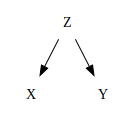

In [3]:
g = gr.Digraph("fork", node_attr={"color": "white"})

g.node("X")
g.node("Z")
g.node("Y")

g.edge("Z", "X")
g.edge("Z", "Y")
g

**The pipe:** $X$ and $Y$ are independent conditional on $Z$.

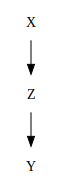

In [4]:
g = gr.Digraph("fork", node_attr={"color": "white"})

g.node("X")
g.node("Z")
g.node("Y")

g.edge("X", "Z")
g.edge("Z", "Y")
g

**The collider:** $X$ and $Y$ are independent, but conditioning on $Z$ may induce association between them.

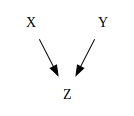

In [5]:
g = gr.Digraph("fork", node_attr={"color": "white"})

g.node("X")
g.node("Z")
g.node("Y")

g.edge("X", "Z")
g.edge("Y", "Z")
g

**The descendant:** $X$ and $Y$ are independent, but conditioning on $D$ may induce association (depending its relationship with $Z$).

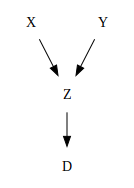

In [6]:
g = gr.Digraph("fork", node_attr={"color": "white"})

g.node("X")
g.node("Z")
g.node("Y")
g.node("D")

g.edge("X", "Z")
g.edge("Y", "Z")
g.edge("Z", "D")
g

### 6E4
How is a biased sample like conditioning on a collider?
Think of the example at the opening of the chapter.

---

Conditioning on a collider is like restricting attention to the subsample where the collider takes a particular value.
If the values of the collider are affected by the other two variables, then this is equivalent to selecting for certain (joint) values of those variables.
This is equivalent to selecting a biased (sub)sample.

## Medium

### 6M1
Modify the DAG on page 186 to include the variable $V$, an unobserved cause of $C$ and $Y$: $C \leftarrow V \rightarrow Y$.
Reanalyze the DAG.
How many paths connect $X$ to $Y$?
Which must be closed?
Which variables should you condition on now?

---

Let's redraw the DAG.

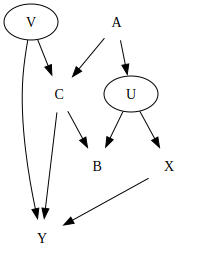

In [8]:
g = gr.Digraph("6m1", node_attr={"color": "white"})

g.node("X")
g.node("Y")
g.node("U", color="black")
g.node("V", color="black")
g.node("A")
g.node("B")
g.node("C")

g.edge("X", "Y")
g.edge("U", "X")
g.edge("A", "U")
g.edge("A", "C")
g.edge("U", "B")
g.edge("C", "B")
g.edge("C", "Y")
g.edge("V", "C")
g.edge("V", "Y")
g

There are now five paths connecting $X$ and $Y$:
1. $X \rightarrow Y$
2. $X \leftarrow U \leftarrow A \rightarrow C \rightarrow Y$
3. $X \leftarrow U \rightarrow B \leftarrow C \rightarrow Y$
2. $X \leftarrow U \leftarrow A \rightarrow C \leftarrow V \rightarrow Y$
3. $X \leftarrow U \rightarrow B \leftarrow C \leftarrow V \rightarrow Y$

Paths 2, and 4 are open and so must be closed.
The others are closed since they contain the confound at $B$.

We can close all open paths by conditioning on $A$.

### 6M2
Sometimes, in order to avoid multicollinearity, people inspect pairwise correlations among predictors before including them in a model.
This is a bad procedure, because what matters is the conditional association, not the association before the variables are included in the model.
To highlight this, consider the DAG $X \to Z \to Y$.
Simulate data from this DAG so that the correlation between $X$ and $Z$ is very large.
Then include both in a model predicting $Y$.
Do you observe any multicollinearity?
Why or why not?
What is different from the legs example in the chapter?

---

Let's simulate some data

In [22]:
N = 100

rng = np.random.default_rng(RANDOM_SEED)
x = rng.normal(loc=0, scale=1, size=N)
z = 1 + 2*x + rng.normal(loc=0, scale=0.5, size=N)
y = 2 - z + rng.normal(loc=0, scale=0.5, size=N)

data = pd.DataFrame({
    "x": x, "y": y, "z": z
})

There is a lot of correlation between the variables

In [23]:
data.corr()

,x,y,z
x,1.000000,-0.915949,0.956554
y,-0.915949,1.000000,-0.956216
z,0.956554,-0.956216,1.000000


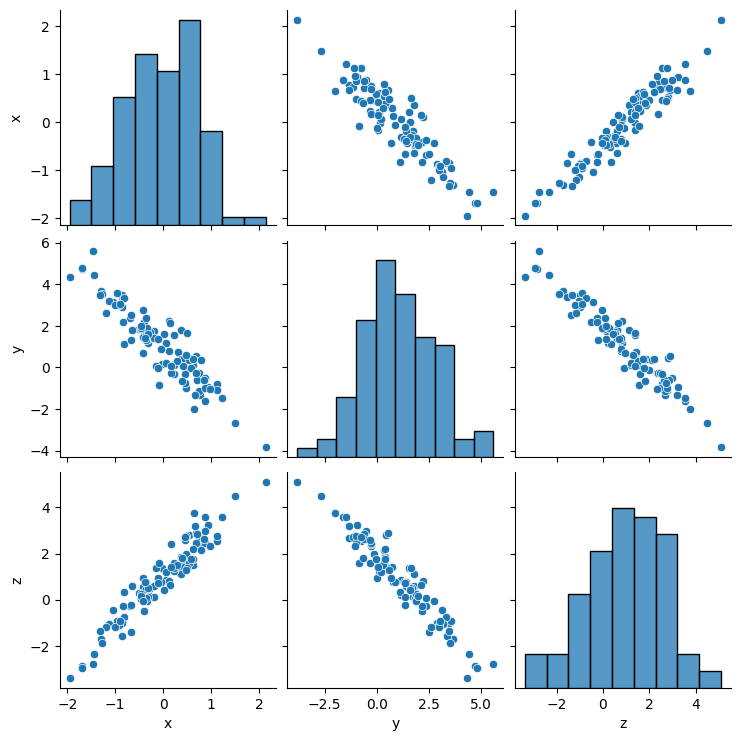

In [39]:
sns.pairplot(data);

Now we'll fit models for $Z$ as functions $X$ and $Y$ separately and together.
I can't be bothered to normalise everything so I'll just use vague priors.

In [31]:
coords = {
    "obs_id": data.index,
}
with pm.Model(coords_mutable=coords) as m_6m2a:
    # data
    x = pm.MutableData("x", data.x, dims="obs_id")
    
    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=2)
    beta_x = pm.Normal("beta_x", mu=0, sigma=2)
    sigma = pm.Exponential("sigma", lam=1)
    
    # model
    mu = pm.Deterministic("mu", alpha + beta_x * x, dims="obs_id")
    
    # likelihood
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=data.y, dims="obs_id")
    
    # sample
    trace_6m2a = pm.sample(random_seed=RANDOM_SEED)
    

with pm.Model(coords_mutable=coords) as m_6m2b:
    # data
    z = pm.MutableData("z", data.z, dims="obs_id")
    
    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=2)
    beta_z = pm.Normal("beta_z", mu=0, sigma=2)
    sigma = pm.Exponential("sigma", lam=1)
    
    # model
    mu = pm.Deterministic("mu", alpha + beta_z * z, dims="obs_id")
    
    # likelihood
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=data.y, dims="obs_id")
    
    # sample
    trace_6m2b = pm.sample(random_seed=RANDOM_SEED)

    
with pm.Model(coords_mutable=coords) as m_6m2c:
    # data
    x = pm.MutableData("x", data.x, dims="obs_id")
    z = pm.MutableData("z", data.z, dims="obs_id")
    
    # priors
    alpha = pm.Normal("alpha", mu=0, sigma=2)
    beta_x = pm.Normal("beta_x", mu=0, sigma=2)
    beta_z = pm.Normal("beta_z", mu=0, sigma=2)
    sigma = pm.Exponential("sigma", lam=1)
    
    # model
    mu = pm.Deterministic("mu", alpha + beta_x * x + beta_z * z, dims="obs_id")
    
    # likelihood
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=data.y, dims="obs_id")
    
    # sample
    trace_6m2c = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_x, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_z, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta_x, beta_z, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


Now look at the results.

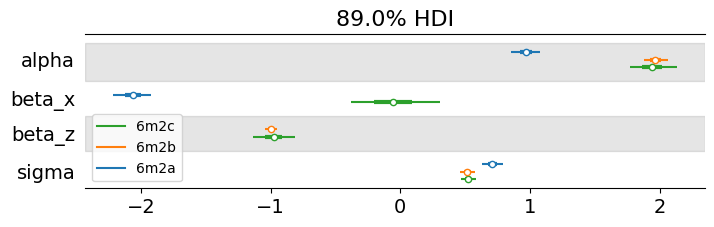

In [36]:
fig, ax = plt.subplots(figsize=(8, 2))

az.plot_forest(
    [trace_6m2a,trace_6m2b, trace_6m2c],
    model_names=["6m2a", "6m2b", "6m2c"],
    var_names=["~mu"],
    combined=True,
    hdi_prob=0.89,
    ax=ax
);

The book defined multicollinearity as follows: each individual predictor helps in predicting the outcome, but neither helps as much once you know the other.
That's not what's happening here.
If we have $Z$ in the model, then adding $X$ appears to increase uncertainty in the posteriors (this is a bit of a mirage - there is a lot of correlation in the posteriors) but it doesn't meaningfully change the estimate of $\beta_Z$.
That is, $Z$ is independent of $Y$ conditional on $X$.
This wasn't the case in the legs example, where there was no direct causal relationship between the two predictors.

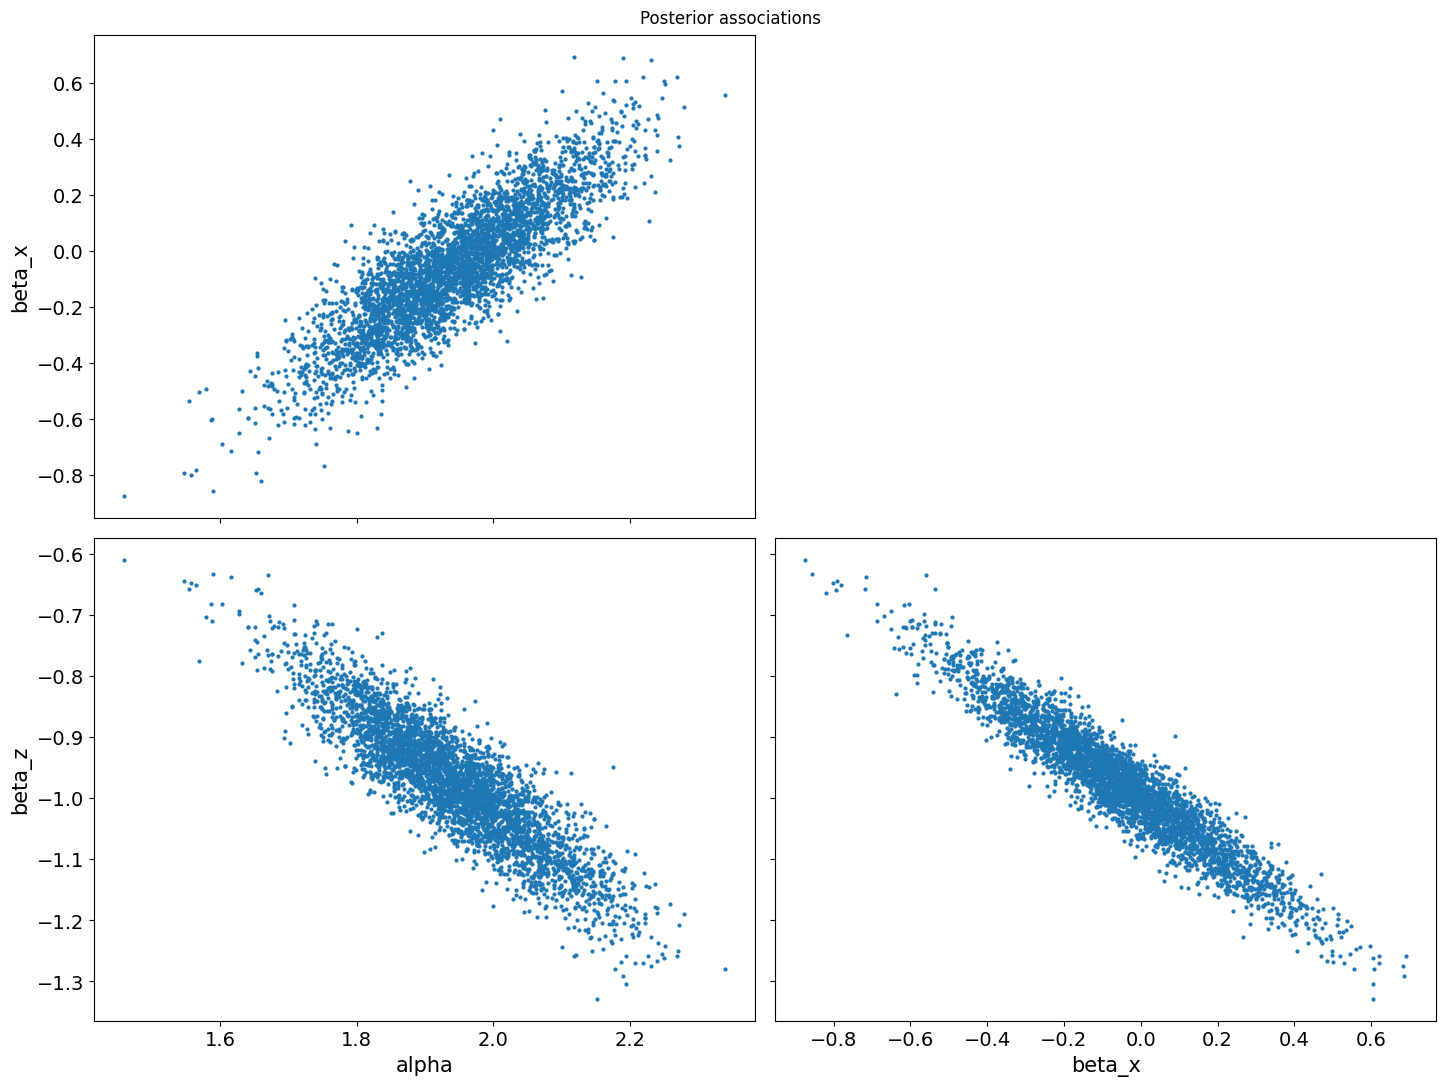

In [42]:
axs = az.plot_pair(
    trace_6m2c,
    var_names=["alpha", "beta_x", "beta_z"],
)
fig = axs[0][0].get_figure()
fig.suptitle("Posterior associations")
fig.tight_layout();

### 6M3
Learning to analyze DAGs requires practice.
For each of the four DAGs below, state which variables, if any, you must adjust for (condition on) to estimate the total causal influence of $X$ on $Y$.

---

a) Conditioning on $Z$ takes care of both open paths.

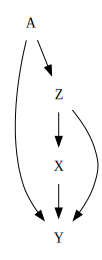

In [46]:
g = gr.Digraph("6m3a", node_attr={"color": "white"})

g.node("X")
g.node("Y")
g.node("Z")
g.node("A")

g.edge("X", "Y")
g.edge("Z", "X")
g.edge("Z", "Y")
g.edge("A", "Z")
g.edge("A", "Y")
g

b) There are two additional paths from $X$ to $Y$, but only the one through $A$ is a backdoor.
But, since $Z$ is a collider this path is already closed.
So we don't need to condition on anything.

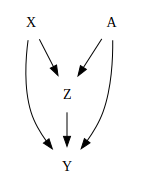

In [47]:
g = gr.Digraph("6m3b", node_attr={"color": "white"})

g.node("X")
g.node("Y")
g.node("Z")
g.node("A")

g.edge("X", "Y")
g.edge("X", "Z")
g.edge("Z", "Y")
g.edge("A", "Z")
g.edge("A", "Y")
g

c) There are two additional paths from $X$ to $Y$, but only the one through $A$ is a backdoor path.
But, this path is already closed because $Z$ is a collider.
So we don't need to condition on any variables.

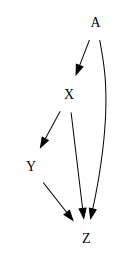

In [48]:
g = gr.Digraph("6m3c", node_attr={"color": "white"})

g.node("X")
g.node("Y")
g.node("Z")
g.node("A")

g.edge("X", "Y")
g.edge("X", "Z")
g.edge("Y", "Z")
g.edge("A", "X")
g.edge("A", "Z")
g

d) Everything is the same as in (c), except $Z$ is no longer a collider.
So we need to close the path through $A$ by conditioning on $A$.

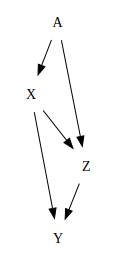

In [49]:
g = gr.Digraph("6m3d", node_attr={"color": "white"})

g.node("X")
g.node("Y")
g.node("Z")
g.node("A")

g.edge("X", "Y")
g.edge("X", "Z")
g.edge("Z", "Y")
g.edge("A", "X")
g.edge("A", "Z")
g

## Hard